In [1]:
!pip install -q transformers[torch] datasets accelerate peft
!pip install -q ipython
!pip install -q wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    InstructBlipProcessor,
    InstructBlipForConditionalGeneration,
    InstructBlipConfig,
    InstructBlipVisionConfig,
    InstructBlipQFormerConfig,
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import os # For setting environment variables if needed

# --- Optional: Set Hugging Face Token (if needed for private access) ---
# from google.colab import runtime
# try:
#     hf_token = runtime.secrets.get("HF_TOKEN")
#     if hf_token:
#         os.environ["HF_TOKEN"] = hf_token
#     else:
#         print("HF_TOKEN secret not found in Colab. Authentication optional for public models.")
# except ImportError:
#      print("Not in Colab environment. Ensure HF_TOKEN is set if needed.")
# Or use: !huggingface-cli login

# --- Configuration Definitions (as per your original script) ---
# These configs guide the modifications below.
# 1. Vision Encoder Configuration
vision_config = InstructBlipVisionConfig(
    hidden_size = 563,
    intermediate_size = 2457,
    num_hidden_layers = 16,
    num_attention_heads = 6,
    image_size = 224,
    patch_size = 14,
    hidden_act = 'gelu',
    layer_norm_eps = 1e-06,
    attention_dropout = 0.0,
    initializer_range = 1e-10,
    qkv_bias = True
)


# 2. Q-Former Configuration
qformer_config = InstructBlipQFormerConfig(
    vocab_size = 30522,
    hidden_size = 307,
    num_hidden_layers = 5,
    num_attention_heads = 5,
    intermediate_size = 1229,
    hidden_act = 'gelu',
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
    pad_token_id = 0,
    position_embedding_type = 'absolute',
    cross_attention_frequency = 2,
    encoder_hidden_size = 1408
)

# --- Load Pre-trained Model ---
model_name = "Salesforce/instructblip-vicuna-7b"
print(f"Loading base model: {model_name}")
model = InstructBlipForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16
)
print("Base model loaded.")

# --- FIX: Tie weights ---
# Addresses: WARNING:accelerate.utils.modeling:The model weights are not tied.
print("Tying model weights...")
model.tie_weights()

# --- Apply Modifications Directly to the Loaded Model ---
print("Applying configuration modifications to the loaded model...")
# 1. Vision Encoder modifications
for name, module in model.vision_model.named_modules():
    if "act" in name or "activation" in name:
        if hasattr(module, "act_fn"):
            module.act_fn = torch.nn.GELU(approximate="tanh")
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.15

# 2. Q-Former modifications
for name, module in model.qformer.named_modules():
    if "act" in name or "activation" in name:
        if hasattr(module, "act_fn"):
            module.act_fn = torch.nn.GELU(approximate="tanh")
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.15

# 3. Language Model modifications
if hasattr(model, "language_model"):
    for name, module in model.language_model.named_modules():
        # Be cautious modifying LM activations extensively
        # if "act" in name and hasattr(module, "act_fn"):
        #     module.act_fn = torch.nn.GELU(approximate="tanh") # Example
        if isinstance(module, torch.nn.Dropout):
            module.p = 0.1 # Example modification
print("Modifications applied.")

# --- FIX: Disable cache for Gradient Checkpointing compatibility ---
# Set this BEFORE unfreezing layers to ensure proper gradient flow
model.config.use_cache = False
print(f"Model config 'use_cache' explicitly set to: {model.config.use_cache}")

# --- Unfreeze Specific Components ---
print("Unfreezing specific model components...")
# 1. Unfreeze the vision encoder
for param in model.vision_model.parameters():
    param.requires_grad = True

# 2. Unfreeze the Q-Former
for param in model.qformer.parameters():
    param.requires_grad = True

# 3. Selectively unfreeze the language model (last few layers)
if hasattr(model, "language_model") and hasattr(model.language_model, "model") and hasattr(model.language_model.model, "layers"):
    num_layers = len(model.language_model.model.layers)
    layers_to_unfreeze = 4
    print(f"Unfreezing last {layers_to_unfreeze} layers of the language model...")
    for i in range(max(0, num_layers - layers_to_unfreeze), num_layers):
        for param in model.language_model.model.layers[i].parameters():
            param.requires_grad = True
else:
    print("Could not find language model layers to unfreeze.")

# FIX: Ensure language model output layer is unfrozen for gradient flow
if hasattr(model.language_model, "lm_head"):
    for param in model.language_model.lm_head.parameters():
        param.requires_grad = True
    print("Language model output layer (lm_head) unfrozen.")

print("Unfreezing complete.")

# --- Enhanced LoRA Configuration ---
lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.1,
    bias="lora_only"
)

# --- Apply LoRA to the Modified Model ---
print("Applying LoRA...")
model = get_peft_model(model, lora_config)
print("LoRA applied.")
model.print_trainable_parameters() # Shows trainable params (unfrozen + LoRA)

# --- FIX: Verify gradient flow ---
print("Verifying gradient flow through model components...")
# Check if key components have requires_grad=True
has_grad_vision = any(p.requires_grad for p in model.vision_model.parameters())
has_grad_qformer = any(p.requires_grad for p in model.qformer.parameters())
has_grad_language = any(p.requires_grad for p in model.language_model.parameters())
has_grad_lora = any(p.requires_grad for n, p in model.named_parameters() if "lora" in n.lower())

print(f"Vision model has trainable parameters: {has_grad_vision}")
print(f"QFormer has trainable parameters: {has_grad_qformer}")
print(f"Language model has trainable parameters: {has_grad_language}")
print(f"LoRA modules have trainable parameters: {has_grad_lora}")

if not (has_grad_vision or has_grad_qformer or has_grad_language or has_grad_lora):
    raise ValueError("No trainable parameters found in the model! Check unfreezing logic.")

# --- Load Processor ---
# FIX: Use use_fast=True to address the slow processor warning
print(f"Loading processor for {model_name}...")
processor = InstructBlipProcessor.from_pretrained(model_name, use_fast=True)
print("Processor loaded.")

# --- Load Dataset ---
data_path = '/content/test-00000-of-00001.parquet' # Make sure this path is correct
print(f"Loading dataset from: {data_path}")
dataset = load_dataset('parquet', data_files=data_path)
print(f"Dataset loaded: {dataset}")

# --- Custom Preprocessing Function ---
def preprocess_function(examples):
    # Process images and queries
    inputs = processor(
        images=examples['image'],
        text=examples['query'],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    # Process responses (targets/labels)
    targets = processor(
        text=examples['response'],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    inputs["labels"] = targets.input_ids
    return inputs

# Process dataset and remove original columns that are now redundant
print("Preprocessing dataset...")

# List of columns generated by the processor/preprocess_function that are needed
# Adjust this list based on exactly what your model+collator expect
# Typically includes inputs for vision, qformer, language model, and labels
# Check model.forward() signature or docs if unsure
processed_columns = ['input_ids', 'attention_mask', 'pixel_values', 'labels', 'qformer_input_ids', 'qformer_attention_mask']

# Get the list of original columns to remove
original_columns_to_remove = [
    col for col in dataset['train'].column_names
    if col not in processed_columns # Keep processed columns
]
# Make sure we don't accidentally try to remove columns needed by the function itself if map uses them
# (image, query, response are used as input to preprocess_function)
# The safe way is to remove columns *after* processing them.

train_dataset = dataset['train'].select(range(1000)).map(
    preprocess_function,
    batched=True,
    # Remove the original columns that were used for preprocessing and are no longer needed
    remove_columns=['image', 'query', 'response', 'id', 'human_ranking', 'models', 'judge', 'rationale', 'query_source', 'ground_truth'] # List all original cols explicitly
)
print(f"Dataset preprocessed. Columns removed. Final features: {train_dataset.features}")

# --- FIX: Verify dataset contains expected features ---
print("Verifying dataset features...")
expected_features = ['input_ids', 'attention_mask', 'pixel_values', 'labels']
missing_features = [feat for feat in expected_features if feat not in train_dataset.features]
if missing_features:
    raise ValueError(f"Dataset is missing expected features: {missing_features}")
print("Dataset features verified.")

# --- Data Collator ---
data_collator = DataCollatorForSeq2Seq(
    tokenizer=processor.tokenizer,
    model=model,
    label_pad_token_id=processor.tokenizer.pad_token_id, # Pad labels with pad token ID
    pad_to_multiple_of=8 # Optimize for fp16
)

# --- Optimized Training Arguments ---
# All optimizer settings (LR, decay, type) are defined here now
training_args = TrainingArguments(
    output_dir='./instructblip-advanced-finetized',
    # FIX: Provide a unique run name for wandb
    run_name='instructblip-modified-unfrozen-lora-fixed',
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16, # Effective batch size = 32
    num_train_epochs=3,
    # --- Optimizer Settings ---
    learning_rate=5e-6,         # Single LR for all trainable parameters
    weight_decay=0.01,          # Weight decay
    adam_beta1=0.9,             # AdamW beta1
    adam_beta2=0.999,           # AdamW beta2
    adam_epsilon=1e-8,          # AdamW epsilon
    optim="adamw_torch_fused",  # Use fused AdamW if available, falls back otherwise
    # --- Scheduler Settings ---
    lr_scheduler_type="cosine", # Scheduler type
    warmup_ratio=0.05,          # Warmup ratio
    # --- Other Settings ---
    fp16=True,
    logging_steps=5,
    save_strategy="steps",
    save_steps=100, # Adjust frequency as needed
    # FIX: Use evaluation_strategy (correct parameter name)
    evaluation_strategy="no",
    save_total_limit=2,
    load_best_model_at_end=False,
    # FIX: Set gradient_checkpointing to False if it causes issues
    gradient_checkpointing=False, # Disable gradient checkpointing to troubleshoot gradient issues
    # FIX: Add label_names here
    label_names=["labels"],
    max_grad_norm=1.0, # Gradient clipping
    group_by_length=True,
    report_to="wandb", # Ensure wandb is installed and logged in
    remove_unused_columns=False # Important: Keep False as we map manually and collator needs specific cols
)


Loading base model: Salesforce/instructblip-vicuna-7b


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/104k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/9.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Base model loaded.
Tying model weights...
Applying configuration modifications to the loaded model...
Modifications applied.
Model config 'use_cache' explicitly set to: False
Unfreezing specific model components...
Unfreezing last 4 layers of the language model...
Language model output layer (lm_head) unfrozen.
Unfreezing complete.
Applying LoRA...
LoRA applied.
trainable params: 159,907,840 || all params: 8,073,634,560 || trainable%: 1.9806
Verifying gradient flow through model components...
Vision model has trainable parameters: False
QFormer has trainable parameters: False
Language model has trainable parameters: True
LoRA modules have trainable parameters: True
Loading processor for Salesforce/instructblip-vicuna-7b...


preprocessor_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

Processor loaded.
Loading dataset from: /content/test-00000-of-00001.parquet


Generating train split: 0 examples [00:00, ? examples/s]

Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['id', 'query', 'response', 'image', 'human_ranking', 'models', 'judge', 'rationale', 'query_source', 'ground_truth'],
        num_rows: 1250
    })
})
Preprocessing dataset...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset preprocessed. Columns removed. Final features: {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'qformer_input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'qformer_attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
Verifying dataset features...
Dataset features verified.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [3]:

# --- Initialize Trainer ---
# We DO NOT pass the `optimizers` argument anymore.
# Trainer will create the optimizer and scheduler based on `training_args`.
print("Initializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=None, # No evaluation during training in this setup
    data_collator=data_collator,
    # optimizers=(get_optimizer(), None) # <= REMOVED THIS LINE
)
print("Trainer initialized. Optimizer and scheduler will be created by Trainer.")

# --- FIX: Add a small test to verify forward pass works ---
print("Testing forward pass with a small batch...")
try:
    # Get a small batch from the dataset
    small_batch = next(iter(trainer.get_train_dataloader()))
    # Move to the same device as the model
    small_batch = {k: v.to(model.device) if isinstance(v, torch.Tensor) else v for k, v in small_batch.items()}
    # Run a forward pass
    with torch.no_grad():
        outputs = model(**small_batch)
    print("Forward pass successful!")

    # Test backward pass with a single example
    single_example = {k: v[:1] if isinstance(v, torch.Tensor) else v for k, v in small_batch.items()}
    outputs = model(**single_example)
    loss = outputs.loss
    loss.backward()
    print("Backward pass successful!")
except Exception as e:
    print(f"Error during test forward/backward pass: {e}")
    print("This indicates there may still be issues with the model configuration.")
    raise e

# --- Optional: Enable Anomaly Detection for Debugging RuntimeErrors ---
torch.autograd.set_detect_anomaly(True)

# --- Train the Model ---
print("Starting training...")
try:
    trainer.train()
    print("Training finished successfully.")
except RuntimeError as e:
    print(f"RuntimeError during training: {e}")
    print("This might still be related to gradient flow. Check:")
    print("1. If all intended layers are unfrozen and require gradients.")
    print("2. If LoRA parameters require gradients.")
    print("3. If gradient checkpointing is causing issues (try setting gradient_checkpointing=False).")
    print("4. Input/label shapes and padding.")
    raise e # Re-raise the exception after printing advice

# --- Save the Final Model and Processor ---
print("Saving final model and processor...")
final_save_path = './instructblip-advanced-finetized-final'
trainer.save_model(final_save_path) # Saves the adapter config and weights
processor.save_pretrained(final_save_path)
# Optional: Save the full merged model if needed
# merged_model = model.merge_and_unload()
# merged_model.save_pretrained(final_save_path + "-merged")
print(f"Adapter model and processor saved to {final_save_path}")


Initializing Trainer...
Trainer initialized. Optimizer and scheduler will be created by Trainer.
Testing forward pass with a small batch...
Forward pass successful!
Backward pass successful!
Starting training...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mfjh2222 (mfjh2222-kfupm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
5,10.741400
10,9.261700
15,7.568200
20,7.149300
25,5.771700
30,5.388200
35,5.969000
40,5.294400
45,5.286600


Training finished successfully.
Saving final model and processor...
Adapter model and processor saved to ./instructblip-advanced-finetized-final


Loading base model: /content/instructblip-advanced-finetized-final


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Base model loaded.
Loading LoRA adapter from: ./instructblip-advanced-finetized-final
LoRA adapter loaded and applied.
Loading processor from: ./instructblip-advanced-finetized-final
Processor loaded.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model moved to cuda and set to evaluation mode.
Loading dataset from: /content/test-00000-of-00001.parquet
Dataset loaded.
Selected sample index: 800
Preparing inputs...
Checking processor output keys: dict_keys(['input_ids', 'attention_mask', 'qformer_input_ids', 'qformer_attention_mask', 'pixel_values'])
Generating response...
Decoding response...
------------------------------
QUERY: Tell me what catches your eye in the image, and describe those elements in depth.
------------------------------
ACTUAL RESPONSE (from dataset): ['A blonde-haired woman in a black shirt, standing against a white brick wall, holds up a blue water bottle with the text "Mock Up" on it.', "A blonde woman, exuding joy and confidence, is the focal point of the image. She's holding a blue water bottle with black writing on it. The simplicity of the background featuring a white brick wall adds to the overall appeal of the photo."]
------------------------------
GENERATED RESPONSE (fine-tuned model): a woman hol

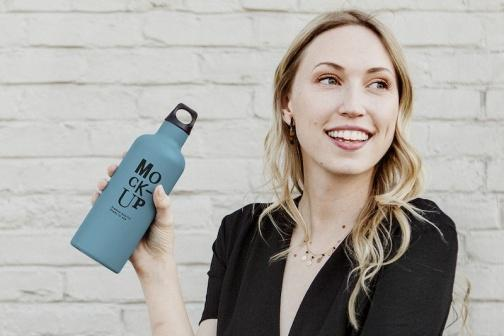

In [4]:
import torch
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
from peft import PeftModel, PeftConfig
from datasets import load_dataset
from PIL import Image
import requests

# --- Configuration ---
base_model_name = "/content/instructblip-advanced-finetized-final"
adapter_path = './instructblip-advanced-finetized-final'
data_path = '/content/test-00000-of-00001.parquet'

# --- Load Base Model ---
print(f"Loading base model: {base_model_name}")
model = InstructBlipForConditionalGeneration.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16, # Use float16 if trained with fp16
    # device_map="auto" # Load base model first, then apply adapter + modifications
)
print("Base model loaded.")

# --- Load LoRA Adapter ---
print(f"Loading LoRA adapter from: {adapter_path}")
# Apply the adapter ON TOP of the now-modified base model
model = PeftModel.from_pretrained(model, adapter_path)
print("LoRA adapter loaded and applied.")

# --- Load Processor ---
print(f"Loading processor from: {adapter_path}")
processor = InstructBlipProcessor.from_pretrained(adapter_path, use_fast=True)
print("Processor loaded.")

# --- Setup Device and Eval Mode ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(f"Model moved to {device} and set to evaluation mode.")

# --- Load Dataset and Select Sample ---
# (Dataset loading and sample selection code remains the same)
print(f"Loading dataset from: {data_path}")
dataset = load_dataset('parquet', data_files=data_path)
print("Dataset loaded.")
sample_index = 800

sample = dataset['train'][sample_index]
image = sample['image']
query = sample['query']
actual_response = sample['response']
print(f"Selected sample index: {sample_index}")

# --- Prepare Input for Inference ---
print("Preparing inputs...")
inputs = processor(
    images=image,
    text=query,
    return_tensors="pt",
).to(device, torch.float16)

# --- Debug: Check if Q-Former inputs exist ---
print("Checking processor output keys:", inputs.keys())
if 'qformer_input_ids' not in inputs or 'qformer_attention_mask' not in inputs:
    print("!!! WARNING: Processor did not generate expected Q-Former inputs !!!")


# --- Generate Output ---
print("Generating response...")
with torch.no_grad():
    generated_ids = model.generate(
        pixel_values=inputs.pixel_values,
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        # --- >>> ADD THESE LINES <<< ---
        qformer_input_ids=inputs.get('qformer_input_ids'), # Pass Q-Former inputs
        qformer_attention_mask=inputs.get('qformer_attention_mask'), # Pass Q-Former attention mask
        # --- >>> END OF ADDED LINES <<< ---
        max_new_tokens=128,
        num_beams=3,
        do_sample=False,
    )

print("Decoding response...")
# (Decoding and display code remains the same)
input_length = inputs.input_ids.shape[1]
generated_ids_only = generated_ids[:, input_length:]
generated_text = processor.batch_decode(generated_ids_only, skip_special_tokens=True)[0].strip()

# --- Display Results ---
# (Display code remains the same)
print("-" * 30)
print(f"QUERY: {query}")
print("-" * 30)
print(f"ACTUAL RESPONSE (from dataset): {actual_response}")
print("-" * 30)
print(f"GENERATED RESPONSE (fine-tuned model): {generated_text}")
print("-" * 30)
try:
    display(image)
except NameError:
    try: image.show()
    except Exception as e: print(f"Could not display image: {e}")




In [5]:

import shutil
import os

# Define the directory to zip
dir_name = './instructblip-advanced-finetized-final'

# Create a zip archive
shutil.make_archive(dir_name, 'zip', dir_name)

# Print a message indicating the zip file is ready for download
print(f"Model saved and zipped.  Download the {dir_name}.zip file.")


Model saved and zipped.  Download the ./instructblip-advanced-finetized-final.zip file.
